### LIBRARY IMPORTATION

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             accuracy_score, precision_score, recall_score, f1_score, silhouette_score, roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')

### DATASET IMPORTATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

BASE = "/content/drive/MyDrive"
credit_card = pd.read_csv(f"{BASE}/creditcard.csv", low_memory=False)

print(credit_card.shape)
credit_card.head()


Mounted at /content/drive
(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
# Check missing values
missing = credit_card.isnull().sum().sum()
print(f"Missing values: {missing}")

# Basic statistics
print(f"\nAmount statistics:")
print(f"  Legitimate - Mean: ${credit_card[credit_card['Class']==0]['Amount'].mean():.2f}")
print(f"  Fraud - Mean: ${credit_card[credit_card['Class']==1]['Amount'].mean():.2f}")

print(f"\nTime range: {credit_card['Time'].min():.0f}s to {credit_card['Time'].max():.0f}s")
print(f"  (~{credit_card['Time'].max()/3600:.1f} hours of transactions)")

# Correlation with fraud
correlations = credit_card.corr()['Class'].abs().sort_values(ascending=False)
print(f"\nTop 5 features correlated with fraud:")
for idx, (feat, corr) in enumerate(list(correlations.items())[1:6], 1):
    print(f"  {idx}. {feat}: {corr:.4f}")

Missing values: 0

Amount statistics:
  Legitimate - Mean: $88.29
  Fraud - Mean: $122.21

Time range: 0s to 172792s
  (~48.0 hours of transactions)

Top 5 features correlated with fraud:
  1. V17: 0.3265
  2. V14: 0.3025
  3. V12: 0.2606
  4. V10: 0.2169
  5. V16: 0.1965


# TARGET VARIABLE ANALYSIS

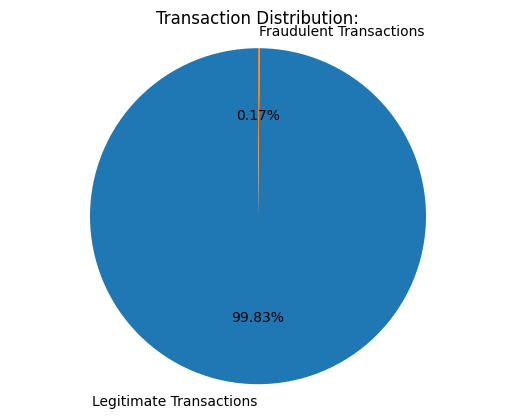

In [ ]:



fraud_count = credit_card['Class'].sum()
legit_count = len(credit_card) - fraud_count
fraud_rate = credit_card['Class'].mean() * 100




labels = ['Legitimate Transactions', 'Fraudulent Transactions']
sizes = [legit_count, fraud_count]

plt.figure()
plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)
plt.title('Transaction Distribution:')
plt.axis('equal')
plt.show()





# FEATURE ENGINEERING

In [ ]:


# Extract hour from Time
credit_card['Hour'] = (credit_card['Time'] / 3600) % 24
print(f"✓ Created 'Hour' feature from Time")

# Select features (excluding Class which is target)
feature_cols = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Hour']

X = credit_card[feature_cols]
y = credit_card['Class']

print(f"✓ Selected {len(feature_cols)} features for modeling")


✓ Created 'Hour' feature from Time
✓ Selected 31 features for modeling


### EDA  

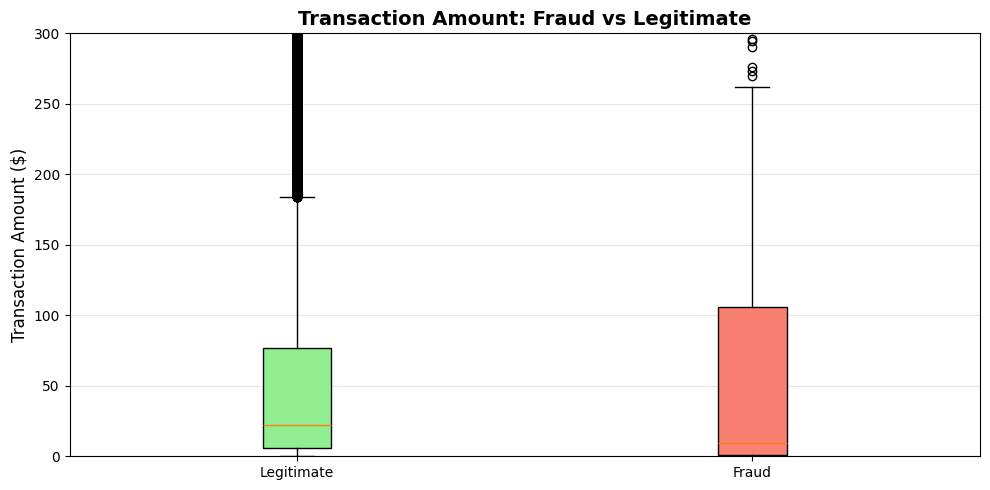

Amount Comparison:
  Legitimate: Mean=$88.29, Median=$22.00
  Fraud:      Mean=$122.21, Median=$9.25


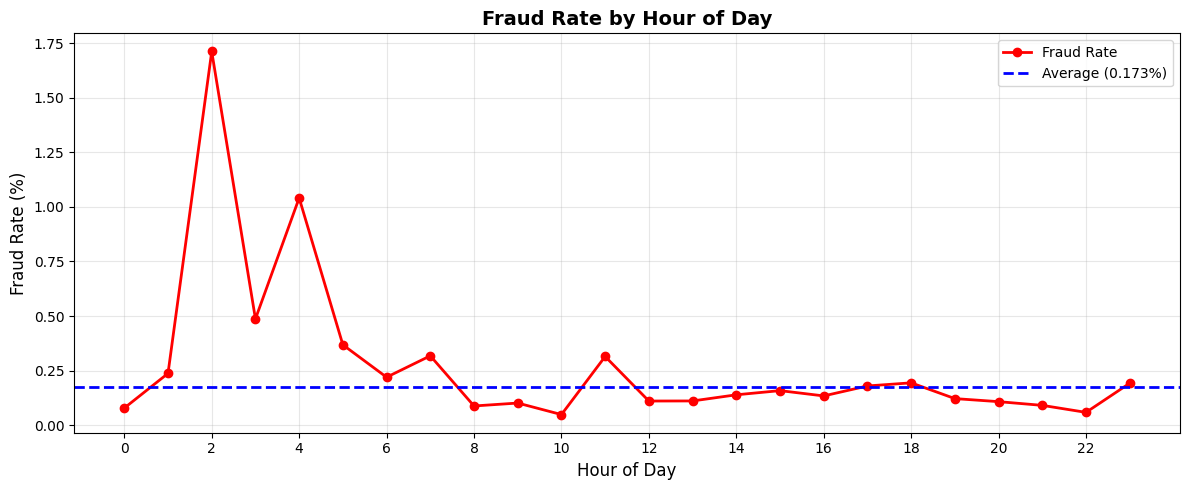


Top 3 Highest Fraud Rate Hours:
  02:00 - 1.713%
  04:00 - 1.041%
  03:00 - 0.487%


In [ ]:

 #AMOUNT DISTRIBUTION


# Just one simple plot showing the difference
fig, ax = plt.subplots(figsize=(10, 5))

# Simple box plot
data = [credit_card[credit_card['Class']==0]['Amount'],
        credit_card[credit_card['Class']==1]['Amount']]

bp = ax.boxplot(data, labels=['Legitimate', 'Fraud'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('salmon')

ax.set_ylabel('Transaction Amount ($)', fontsize=12)
ax.set_title('Transaction Amount: Fraud vs Legitimate', fontsize=14, fontweight='bold')
ax.set_ylim([0, 300])
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Simple stats
print("Amount Comparison:")
print(f"  Legitimate: Mean=${credit_card[credit_card['Class']==0]['Amount'].mean():.2f}, Median=${credit_card[credit_card['Class']==0]['Amount'].median():.2f}")
print(f"  Fraud:      Mean=${credit_card[credit_card['Class']==1]['Amount'].mean():.2f}, Median=${credit_card[credit_card['Class']==1]['Amount'].median():.2f}")



#HOUR PATTERNS


# Create Hour feature if needed
if 'Hour' not in credit_card.columns:
    credit_card['Hour'] = (credit_card['Time'] / 3600) % 24

# Calculate fraud rate by hour
hours = range(24)
fraud_rates = []

for hour in hours:
    hour_data = credit_card[(credit_card['Hour'] >= hour) & (credit_card['Hour'] < hour + 1)]
    fraud_rate = hour_data['Class'].mean() * 100 if len(hour_data) > 0 else 0
    fraud_rates.append(fraud_rate)

# Simple line chart
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(hours, fraud_rates, marker='o', linewidth=2, markersize=6, color='red', label='Fraud Rate')
ax.axhline(y=credit_card['Class'].mean()*100, color='blue', linestyle='--', linewidth=2, label=f'Average ({credit_card["Class"].mean()*100:.3f}%)')

ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Fraud Rate (%)', fontsize=12)
ax.set_title('Fraud Rate by Hour of Day', fontsize=14, fontweight='bold')
ax.set_xticks(range(0, 24, 2))
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show peak hours
fraud_df = pd.DataFrame({'Hour': hours, 'Fraud_Rate_%': fraud_rates}).sort_values('Fraud_Rate_%', ascending=False)
print("\nTop 3 Highest Fraud Rate Hours:")
for i, row in fraud_df.head(3).iterrows():
    print(f"  {int(row['Hour']):02d}:00 - {row['Fraud_Rate_%']:.3f}%")

###  DATA PREPROCESSING

In [ ]:



# Train–test split (70% training, 30% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed.")



Data preprocessing completed.


# Logistic Regression

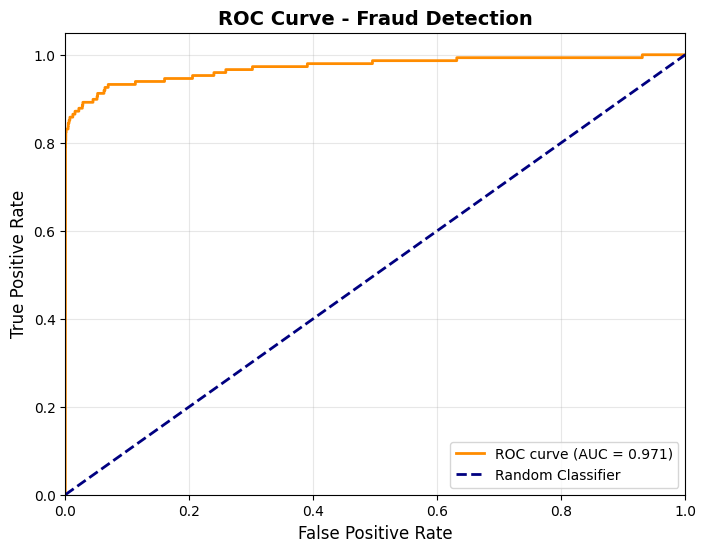


CLASSIFICATION REPORT TABLE:


,precision,recall,f1-score,support
Legitimate,0.999772,0.978287,0.988913,85295.000000
Fraud,0.065119,0.871622,0.121184,148.000000
accuracy,0.978102,0.978102,0.978102,0.978102
macro avg,0.532445,0.924954,0.555048,85443.000000
weighted avg,0.998153,0.978102,0.987410,85443.000000


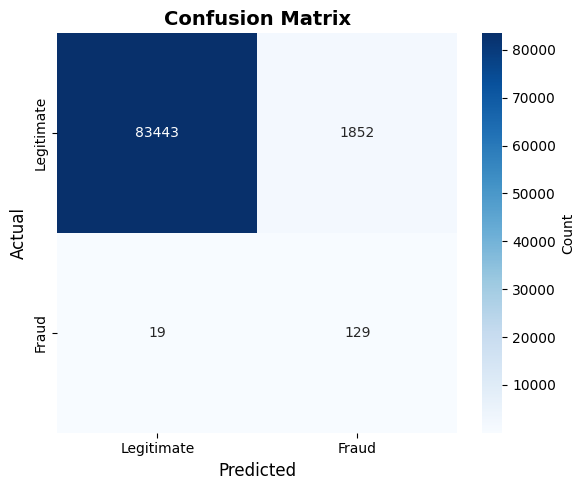

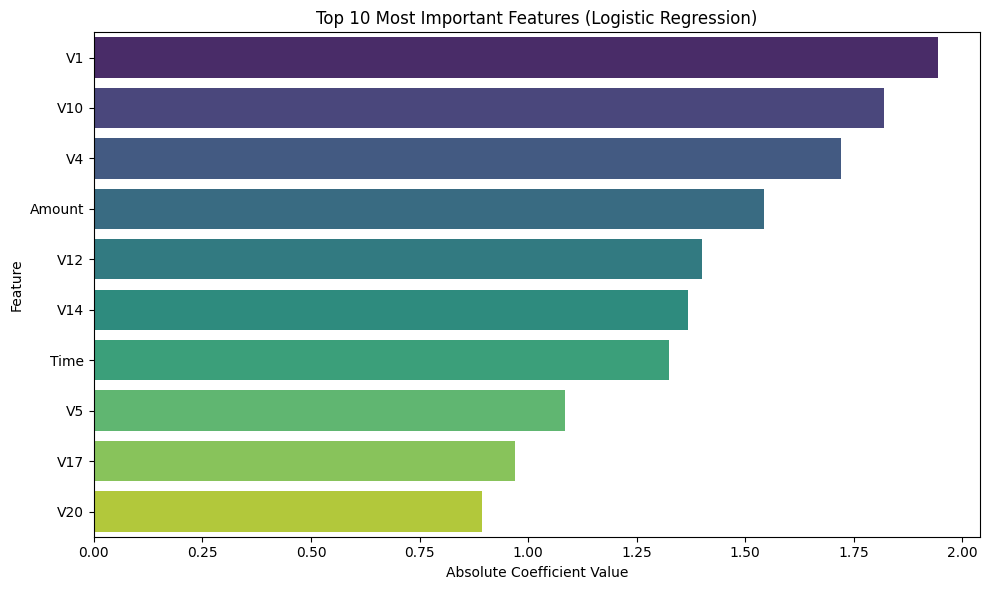

In [ ]:

log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced',
    solver='liblinear'
)


log_reg.fit(X_train_scaled, y_train)

y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

# -----------------------------
#ROC-AUC CURVE
# -----------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Fraud Detection', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


# Classification Report


report = classification_report(
    y_test, y_pred,
    target_names=["Legitimate", "Fraud"],
    output_dict=True
    )
report_df = pd.DataFrame(report).T
print("\nCLASSIFICATION REPORT TABLE:")
display(report_df)

# -----------------------------
# 5. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'],
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# -----------------------------
# 6. Feature Importance
# -----------------------------
feature_importance = (
    pd.DataFrame({
        "feature": feature_cols,
        "coef": log_reg.coef_[0]
        })
    .assign(abs_coef=lambda df: df["coef"].abs())
    .sort_values("abs_coef", ascending=False)
    )
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance.head(10),
    x="abs_coef",
    y="feature",
    palette="viridis"
    )
plt.title("Top 10 Most Important Features (Logistic Regression)")
plt.xlabel("Absolute Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### KMEANS


Using fixed sample of 30,000 rows for silhouette optimisation...

Evaluating silhouette scores:
  k=2: Silhouette=0.0647
  k=3: Silhouette=0.0740
  k=4: Silhouette=0.0723
  k=5: Silhouette=0.0783
  k=6: Silhouette=0.0777
  k=7: Silhouette=0.0816
  k=8: Silhouette=0.0864
  k=9: Silhouette=0.0910
  k=10: Silhouette=0.0709

Training final MiniBatchKMeans with k=9 on FULL dataset...


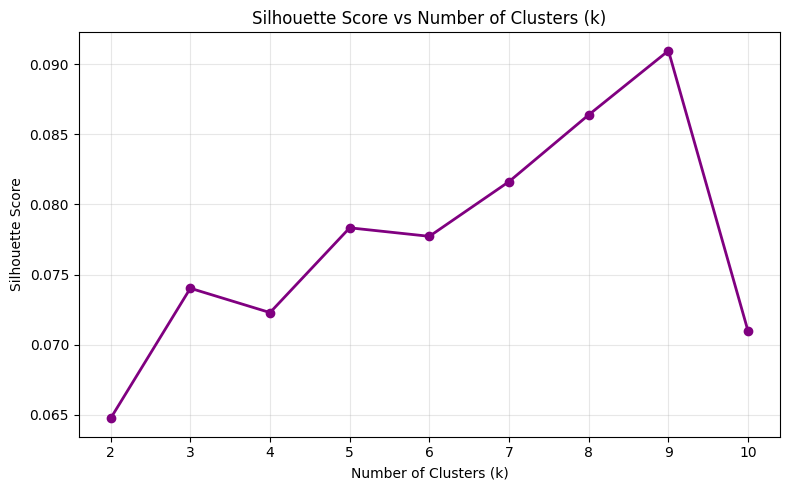

 K-Means clustering complete


In [ ]:

np.random.seed(42)

sample_size = min(30000, len(X_train_scaled))
sample_idx = np.random.choice(len(X_train_scaled), sample_size, replace=False)
X_sample = X_train_scaled[sample_idx]

print(f"\nUsing fixed sample of {sample_size:,} rows for silhouette optimisation...")


# DETERMINISTIC KMEANS FOR FINDING OPTIMAL k

silhouette_scores = []
K_range = range(2, 11)

print("\nEvaluating silhouette scores:")
for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels = kmeans.fit_predict(X_sample)
    sil = silhouette_score(X_sample, labels)
    silhouette_scores.append(sil)
    print(f"  k={k}: Silhouette={sil:.4f}")

optimal_k = K_range[np.argmax(silhouette_scores)]



#  FINAL MODEL USING MINIBATCHKMEANS

print(f"\nTraining final MiniBatchKMeans with k={optimal_k} on FULL dataset...")

kmeans_final = MiniBatchKMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=10,
    batch_size=2000
)

train_clusters = kmeans_final.fit_predict(X_train_scaled)
test_clusters = kmeans_final.predict(X_test_scaled)

#  SILHOUETTE ELBOW PLOT

plt.figure(figsize=(8, 5))
plt.plot(list(K_range), silhouette_scores, marker='o', linewidth=2, color='purple')
plt.title("Silhouette Score vs Number of Clusters (k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(list(K_range))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


print(" K-Means clustering complete")


In [ ]:

# CLUSTER CHARACTERISTICS



df_train_cluster = X_train.copy()
df_train_cluster['cluster'] = train_clusters
df_train_cluster['fraud'] = y_train.values

print("\nCluster Analysis:")
for i in range(optimal_k):
    cluster_data = df_train_cluster[df_train_cluster['cluster'] == i]
    fraud_rate = cluster_data['fraud'].mean()
    cluster_size = len(cluster_data)
    avg_amount = cluster_data['Amount'].mean()
    avg_hour = cluster_data['Hour'].mean()

    print(f"\nCluster {i}:")
    print(f"  Size: {cluster_size:,} ({cluster_size/len(df_train_cluster)*100:.1f}%)")
    print(f"  Fraud Rate: {fraud_rate*100:.3f}%")
    print(f"  Avg Amount: ${avg_amount:.2f}")
    print(f"  Avg Hour: {avg_hour:.1f}h")

    # Risk classification
    if fraud_rate > 0.005:
        risk = " HIGH RISK"
    elif fraud_rate > 0.002:
        risk = " MEDIUM RISK"
    else:
        risk = " LOW RISK"
    print(f"  Risk Level: {risk}")


Cluster Analysis:

Cluster 0:
  Size: 28,869 (14.5%)
  Fraud Rate: 0.132%
  Avg Amount: $99.06
  Avg Hour: 15.0h
  Risk Level:  LOW RISK

Cluster 1:
  Size: 43,802 (22.0%)
  Fraud Rate: 0.055%
  Avg Amount: $81.39
  Avg Hour: 15.4h
  Risk Level:  LOW RISK

Cluster 2:
  Size: 31,094 (15.6%)
  Fraud Rate: 0.138%
  Avg Amount: $64.02
  Avg Hour: 14.9h
  Risk Level:  LOW RISK

Cluster 3:
  Size: 40,915 (20.5%)
  Fraud Rate: 0.042%
  Avg Amount: $136.85
  Avg Hour: 15.1h
  Risk Level:  LOW RISK

Cluster 4:
  Size: 1,512 (0.8%)
  Fraud Rate: 3.307%
  Avg Amount: $393.01
  Avg Hour: 14.0h
  Risk Level:  HIGH RISK

Cluster 5:
  Size: 9,262 (4.6%)
  Fraud Rate: 0.065%
  Avg Amount: $125.18
  Avg Hour: 15.0h
  Risk Level:  LOW RISK

Cluster 6:
  Size: 13,882 (7.0%)
  Fraud Rate: 0.475%
  Avg Amount: $59.60
  Avg Hour: 3.9h
  Risk Level:  MEDIUM RISK

Cluster 7:
  Size: 1,858 (0.9%)
  Fraud Rate: 0.969%
  Avg Amount: $17.08
  Avg Hour: 14.6h
  Risk Level:  HIGH RISK

Cluster 8:
  Size: 28,170 (1

### INTEGRATED ANALYSIS: PREDICTION PERFORMANCE BY CLUSTER




In [ ]:


df_test_analysis = X_test.copy()
df_test_analysis['cluster'] = test_clusters
df_test_analysis['actual'] = y_test.values
df_test_analysis['predicted'] = y_pred
df_test_analysis['pred_proba'] = y_proba

print("\nModel Performance by Cluster:")
for i in range(optimal_k):
    mask = df_test_analysis['cluster'] == i
    actual = df_test_analysis[mask]['actual']
    pred = df_test_analysis[mask]['predicted']

    if len(actual) > 0:
        acc = accuracy_score(actual, pred)
        if actual.sum() > 0:  # If there are frauds in this cluster
            prec = precision_score(actual, pred, zero_division=0)
            rec = recall_score(actual, pred, zero_division=0)

            print(f"\nCluster {i}:")
            print(f"  Samples: {len(actual):,}")
            print(f"  Actual Fraud Rate: {actual.mean()*100:.3f}%")
            print(f"  Accuracy: {acc*100:.2f}%")
            print(f"  Precision: {prec:.4f}")
            print(f"  Recall: {rec:.4f}")
        else:
            print(f"\nCluster {i}:")
            print(f"  Samples: {len(actual):,}")
            print(f"  Actual Fraud Rate: 0.000%")
            print(f"  Accuracy: {acc*100:.2f}%")


Model Performance by Cluster:

Cluster 0:
  Samples: 12,326
  Actual Fraud Rate: 0.122%
  Accuracy: 97.48%
  Precision: 0.0347
  Recall: 0.7333

Cluster 1:
  Samples: 18,821
  Actual Fraud Rate: 0.069%
  Accuracy: 98.84%
  Precision: 0.0402
  Recall: 0.6923

Cluster 2:
  Samples: 13,451
  Actual Fraud Rate: 0.164%
  Accuracy: 99.48%
  Precision: 0.2333
  Recall: 0.9545

Cluster 3:
  Samples: 17,548
  Actual Fraud Rate: 0.040%
  Accuracy: 99.09%
  Precision: 0.0128
  Recall: 0.2857

Cluster 4:
  Samples: 626
  Actual Fraud Rate: 3.355%
  Accuracy: 90.42%
  Precision: 0.2593
  Recall: 1.0000

Cluster 5:
  Samples: 3,899
  Actual Fraud Rate: 0.051%
  Accuracy: 97.97%
  Precision: 0.0247
  Recall: 1.0000

Cluster 6:
  Samples: 6,046
  Actual Fraud Rate: 0.331%
  Accuracy: 96.66%
  Precision: 0.0864
  Recall: 0.9500

Cluster 7:
  Samples: 774
  Actual Fraud Rate: 1.292%
  Accuracy: 99.35%
  Precision: 0.6667
  Recall: 1.0000

Cluster 8:
  Samples: 11,952
  Actual Fraud Rate: 0.318%
  Accur

### SAVE RESULTS

In [ ]:


# Summary results
results = {
    'dataset_size': len(credit_card),
    'fraud_count': fraud_count,
    'fraud_rate_%': fraud_rate,
    'train_size': len(X_train),
    'test_size': len(X_test),
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1_score': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_proba),
    'optimal_k': optimal_k,
    'silhouette_score': max(silhouette_scores)
}

pd.DataFrame([results]).to_csv('fraud_detection_results.csv', index=False)
feature_importance.to_csv('feature_importance.csv', index=False)

print("✓ Results saved:")
print("  - fraud_detection_results.csv")
print("  - feature_importance.csv")




✓ Results saved:
  - fraud_detection_results.csv
  - feature_importance.csv
